In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
from KT_model import *
from SpecRepMethod import SRM
from utils import EPSD_show, simple_interpol2d

In [2]:
# %matplotlib widget

In this file, I'll learn how to obtain the EPSD from a real earthquake acceleratioin recording by STFT

In [3]:
# import the El centro signal

col_names_NS = ['time', 'NS']

df_NS = pd.read_table('/Users/leslie/Google Drive/Paper Paper Paper/proposed_papers_PhD_UoL/By topic/[Project] Missing data imputation in incomlete ground motion/Time domain method/Playtoy_data/El centro earthquake data/elcentro_NS.dat', 
                   delimiter=' ', names=col_names_NS)

In [4]:
t_axis = df_NS['time']
amp_axis = df_NS['NS']

In [5]:
FS = int(1 / (t_axis[3] - t_axis[2]))

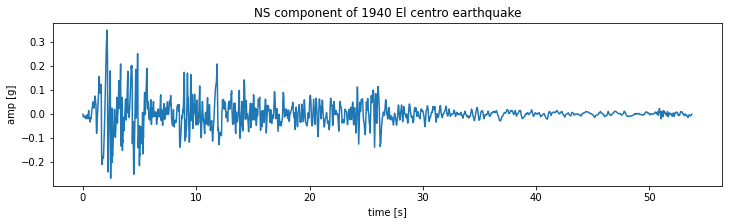

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(t_axis, amp_axis)
plt.title('NS component of 1940 El centro earthquake')
plt.xlabel('time [s]')
plt.ylabel('amp [g]')
plt.show()

#### Using `signal.stft`

In [ ]:
f, t, Zxx = signal.stft(amp_axis, FS, nperseg=128)

In [ ]:
f.shape

In [ ]:
t.shape

In [ ]:
Zxx.shape

Number of frequency bins = $\frac{framesize}{2}+1$.

Ergo, apparantly, the long the 'framesize', i.e. `nperseg`, the more frequency bins, the higher the frequency resolution;

In [ ]:
128/2+1

Number of frames = $\frac{samples - framesize}{hopsize}+1$

In [ ]:
(len(amp_axis)-128)/64 + 1

In [ ]:
# t

In [ ]:
# t_axis

Hint: so the the new time resolution is: `dt` = 1.28s

In [ ]:
# as a comparison, see the t_axis of the original signal, dt=0.02s

In [ ]:
f, t, Zxx = signal.stft(amp_axis, FS, nperseg = 256)

In [ ]:
Zxx.shape

In [ ]:
plt.pcolormesh(t, f, np.abs(Zxx), cmap='viridis', shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
t

### Using `plt.specgram` to get estimation

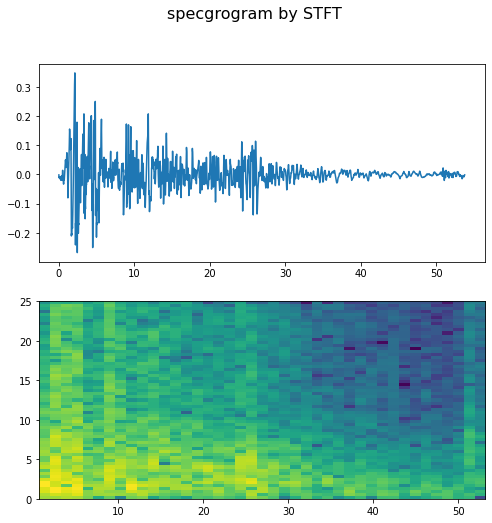

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.plot(t_axis, amp_axis)
Pxx, freqs, t_bins, im = ax2.specgram(amp_axis, 
                                      NFFT =128,
                                      Fs=FS, 
                                      noverlap=64,
                                      mode='psd')
fig.suptitle('specgrogram by STFT', fontsize=16)
plt.show()

In [8]:
Pxx.shape

(65, 41)

In [9]:
freqs.shape

(65,)

#### Plotting the estimated EPSD by STFT

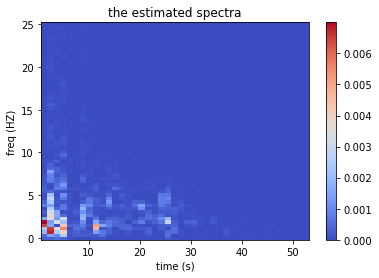

In [10]:
EPSD_show(Pxx, freqs, t_bins, format='2d')

> 3D EPSD plot

<Figure size 432x288 with 0 Axes>

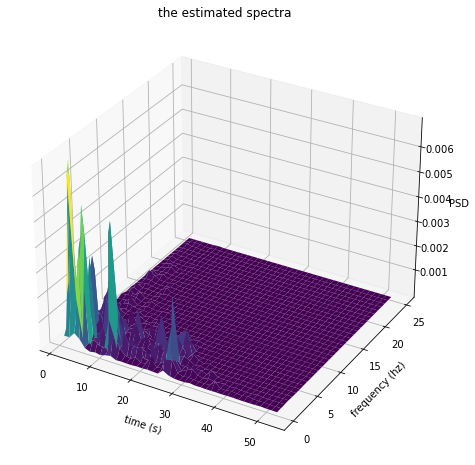

In [11]:
EPSD_show(Pxx, freqs, t_bins, format='3d')
plt.show()

## An explanation of what's going on

To simulate a nonstationary signal, we need to set up the `w_axis` and the `t_axis` for the simuation.
- `w_axis` is set by the `wu` and the `N1` variables;
- `t_axis` is set by the `fs` and `duration` variables;


In practice, to generate a simulation compatible with a recording, we will use the same `fs` and `duration` as the recording; **But** the `w_axis` is set up by ourselves.


Then we will first do **interpolation**. From an estimated specra, what we have is e.g. Swt:(65, 41). But what we want when using SRM is (N1, duration * fs). 

Ergo, we need to do interpolation: (65, 41) -> (N1, duration * fs)







> ''' stationary Sww -> a shape (N1, ) '''
Hint: the simplest case, only care resolution in `w_axis` and no `t_axis` is involved;
Since we are using a continuous func `parameterized_KT_model`, any input w will have a value;
so all good
Sww = PSDF(w_n)
back up
A_n = np.sqrt(2 * parameterize_KT_model(w_n) * delta_w)
'''  non-stationary: S(w, t), which should have a shape (N1, duration * Fs) '''
Hint: in this situation, we don't need to worry about t dimension;
Sww = EPSD(w_n) -> (N1, t)
a hint: for fs=100, duration=16 -> t = (1600, )
Sww = nonstatinary_model(w_n)

> Since we already have the estimated spectra by STFT, we try the **SRM**

In [12]:
from_esti_instance = SRM(wu=25 * np.pi, 
                         N1=1024, 
                         fs=50, 
                         duration=50)

In [13]:
# Take a look at the shape
print("the shape of the w axis:", from_esti_instance.w_axis_4simu.shape)
print("the shape of the time axis:", from_esti_instance.t_axis_4simu.shape)

the shape of the w axis: (1024,)
the shape of the time axis: (2500,)


### Doing 2D interpolation

In [14]:
# Swt = from_esti_instance.interpo_spectra(Pxx, freqs, t_bins, plotting=True, format='2d')

In [15]:
# Swt2 = from_esti_instance.interpo_spectra(Pxx, freqs, t_bins, plotting=True, format='3d')

#### Simulations

the lower limit of sampling frequency: 25
the length of the simulation (2500,)


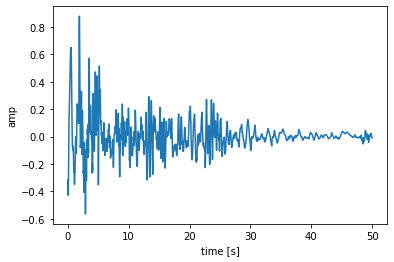

In [16]:
simulation = from_esti_instance.nonsta_simulation(Pxx, freqs, t_bins, plotting=False)

<Figure size 432x288 with 0 Axes>

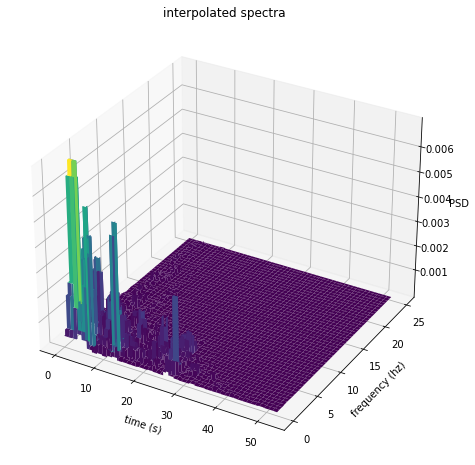

In [19]:
# if we really want to see the interpolated spectra
from_esti_instance._get_interpolated_spectra(format='3d')

## Import another real recording

In [ ]:
ESM_path='/Users/leslie/Documents/GitHub_repos/ImputeIntervalGM/1the target accelerogram/ESM_test3/IT.ACC.00.HGN.D.EMSC-20161030_0000029.ACC.MP.ASC'

In [ ]:
acc_tg = np.loadtxt(ESM_path, skiprows=64)

In [ ]:
acc_tg.shape

In [ ]:
t_axis = np.arange(0, len(acc_tg)*0.005, 0.005)

In [ ]:
t_axis.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 8))
ax1.plot(t_axis, acc_tg)
Pxx, freqs, t_bins, im = ax2.specgram(acc_tg, 
                                      NFFT = 128,
                                      Fs=200, 
                                      noverlap=64,
                                      mode='psd')
plt.show()

In [ ]:
Pxx.shape

In [ ]:
from_esti_instance = SRM(wu=25 * 2 * np.pi, 
                         N1=1024, 
                         fs=200, 
                         duration=35)

In [ ]:
# Take a look at the shape
print("the shape of the w axis:", from_esti_instance.w_axis_4simu.shape)
print("the shape of the time axis:", from_esti_instance.t_axis_4simu.shape)

In [ ]:
# try method3
a_simulation = from_esti_instance.SpecRepsentation3(Pxx, t_bins=t_bins, plot='y')

In [ ]:
freqs.shape